In [1]:
import numpy as np
import json
import os
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import multiprocessing
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
import pickle
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow
from tensorflow.python.keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import Adam
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import pandas as pd
from matplotlib import pyplot as plt
import sys
from scipy import stats
# gradient boosted trees tend to do well on problems like this

BIDS_path = 'C:\\Users\\ICN_admin\\Documents\\BIDS\\'
subject_id = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
out_path = 'C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\dat\\'

def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]

def create_model():
    #start the model making process and create our first layer
    model = Sequential()
    model.add(Dense(num_input_nodes, input_shape=(40,), activation=activation
                   ))
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
    #add our classification layer.
    model.add(Dense(1,activation='linear'))

    #setup our optimizer and compile
    adam = Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='mean_squared_error',
                 metrics=['mse'])
    return model

space_NN = [Real(low=1e-4, high=1e-2, prior='log-uniform', name='learning_rate'),
              Integer(low=1, high=3, name='num_dense_layers'),
              Integer(low=1, high=10, prior='uniform', name='num_input_nodes'),
              Integer(low=1, high=10, name='num_dense_nodes'),
              Categorical(categories=['relu', 'tanh'], name='activation')
             ]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space_NN)
def objective(**params):
    print(params)

    global learning_rate
    learning_rate=params["learning_rate"]
    global num_dense_layers
    num_dense_layers=params["num_dense_layers"]
    global num_input_nodes
    num_input_nodes=params["num_input_nodes"]
    global num_dense_nodes
    num_dense_nodes=params["num_dense_nodes"]
    global activation
    activation=params["activation"]



    model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=300, verbose=0)

    cv_res = cross_val_score(model, X_time, y_time, cv=2, n_jobs=1, scoring="r2")

    #kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

    #cv_res = cross_val_score(reg, X_time, y_time, cv=3, n_jobs=-1,
    #                                scoring="r2")
    cv_res[np.where(cv_res < 0)[0]] = 0
    return -np.mean(cv_res)
    #return -cv_result['test-r2-mean'].iloc[-1]

n_features = 40
space_XGB  = [Integer(1, 100, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(10**0, 10**3, "log-uniform", name='n_estimators'), 
          Real(10**0, 10**1, "uniform", name="gamma")]

@use_named_args(space_XGB)
def objective_XGB(**params):
    print(params)
    
    params_ = {'max_depth': int(params["max_depth"]),
         'gamma': params['gamma'],
         'n_estimators': int(params["n_estimators"]),
         'learning_rate': params["learning_rate"],
         'subsample': 0.8,
         'eta': 0.1,
         'disable_default_eval_metric' : 1} 
         #'tree_method' : 'gpu_hist', 
        #'gpu_id' : 1}
    
    cv_result = xgb.cv(params_, dtrain, num_boost_round=30, feval=evalerror, nfold=3)
    
    #reg.set_params(**params)
    #cv_res = cross_val_score(reg, X_time, y_time, cv=3, n_jobs=-1,
    #                                scoring="r2")
    #cv_res[np.where(cv_res < 0)[0]] = 0
    #return -np.mean(cv_res)
    return -cv_result['test-r2-mean'].iloc[-1]

Using TensorFlow backend.


In [2]:
LM_res = {}
for patient in subject_id:
    print(patient)
    LM_res[patient] = {}
    with open('Redo_lmelasticnet_sub_'+patient+'.p', 'rb') as input_file:
        dat = pickle.load(input_file)
    channels = list(dat.keys())
    for ch in channels:
        mov_ch = list(dat[channels[0]].keys())
        if 'RIGHT' in ch:
            if 'RIGHT' in mov_ch[0]:
                r2_ips = -dat[ch][mov_ch[0]].fun; param_ips = dat[ch][mov_ch[0]].x
                r2_con = -dat[ch][mov_ch[1]].fun; param_con = dat[ch][mov_ch[1]].x
            elif 'RIGHT' in mov_ch[1]:
                r2_ips = -dat[ch][mov_ch[1]].fun; param_ips = dat[ch][mov_ch[1]].x
                r2_con = -dat[ch][mov_ch[0]].fun; param_con = dat[ch][mov_ch[0]].x
        elif 'LEFT' in ch:
            if 'LEFT' in mov_ch[0]:
                r2_ips = -dat[ch][mov_ch[0]].fun; param_ips = dat[ch][mov_ch[0]].x
                r2_con = -dat[ch][mov_ch[1]].fun; param_con = dat[ch][mov_ch[1]].x
            elif 'LEFT' in mov_ch[1]:
                r2_ips = -dat[ch][mov_ch[1]].fun; param_ips = dat[ch][mov_ch[1]].x
                r2_con = -dat[ch][mov_ch[0]].fun; param_con = dat[ch][mov_ch[0]].x
        LM_res[patient][ch] = {
            "r2_ips" : r2_ips,
            "r2_con" : r2_con, 
            "param_con" : param_con, 
            "param_ips" : param_ips
        }

XGB_res = {}
for patient in subject_id:
    print(patient)
    XGB_res[patient] = {}
    with open('bo_xgb_sub_'+patient+'.p', 'rb') as input_file:
        dat = pickle.load(input_file)
    channels = list(dat.keys())
    for ch in channels:
        mov_ch = list(dat[channels[0]].keys())
        if 'RIGHT' in ch:
            if 'RIGHT' in mov_ch[0]:
                r2_ips = -dat[ch][mov_ch[0]].fun; param_ips = dat[ch][mov_ch[0]].x
                r2_con = -dat[ch][mov_ch[1]].fun; param_con = dat[ch][mov_ch[1]].x
            elif 'RIGHT' in mov_ch[1]:
                r2_ips = -dat[ch][mov_ch[1]].fun; param_ips = dat[ch][mov_ch[1]].x
                r2_con = -dat[ch][mov_ch[0]].fun; param_con = dat[ch][mov_ch[0]].x
        elif 'LEFT' in ch:
            if 'LEFT' in mov_ch[0]:
                r2_ips = -dat[ch][mov_ch[0]].fun; param_ips = dat[ch][mov_ch[0]].x
                r2_con = -dat[ch][mov_ch[1]].fun; param_con = dat[ch][mov_ch[1]].x
            elif 'LEFT' in mov_ch[1]:
                r2_ips = -dat[ch][mov_ch[1]].fun; param_ips = dat[ch][mov_ch[1]].x
                r2_con = -dat[ch][mov_ch[0]].fun; param_con = dat[ch][mov_ch[0]].x
        XGB_res[patient][ch] = {
            "r2_ips" : r2_ips,
            "r2_con" : r2_con, 
            "param_con" : param_con, 
            "param_ips" : param_ips
        }

# every channel has con. and ips.

NN_res = {}
for patient in subject_id:
    print(patient)
    NN_res[patient] = {}
    with open('nn_sub_cv_'+patient+'.p', 'rb') as input_file:
        dat = pickle.load(input_file)
    channels = list(dat.keys())
    for ch in channels:
        mov_ch = list(dat[channels[0]].keys())
        if 'RIGHT' in ch:
            if 'RIGHT' in mov_ch[0]:
                r2_ips = -dat[ch][mov_ch[0]].fun; param_ips = dat[ch][mov_ch[0]].x
                r2_con = -dat[ch][mov_ch[1]].fun; param_con = dat[ch][mov_ch[1]].x
            elif 'RIGHT' in mov_ch[1]:
                r2_ips = -dat[ch][mov_ch[1]].fun; param_ips = dat[ch][mov_ch[1]].x
                r2_con = -dat[ch][mov_ch[0]].fun; param_con = dat[ch][mov_ch[0]].x
        elif 'LEFT' in ch:
            if 'LEFT' in mov_ch[0]:
                r2_ips = -dat[ch][mov_ch[0]].fun; param_ips = dat[ch][mov_ch[0]].x
                r2_con = -dat[ch][mov_ch[1]].fun; param_con = dat[ch][mov_ch[1]].x
            elif 'LEFT' in mov_ch[1]:
                r2_ips = -dat[ch][mov_ch[1]].fun; param_ips = dat[ch][mov_ch[1]].x
                r2_con = -dat[ch][mov_ch[0]].fun; param_con = dat[ch][mov_ch[0]].x
        NN_res[patient][ch] = {
            "r2_ips" : r2_ips,
            "r2_con" : r2_con, 
            "param_con" : param_con, 
            "param_ips" : param_ips
        }
        
XGB_res_bg = {}
for patient in subject_id:
    print(patient)
    XGB_res_bg[patient] = {}
    with open('bo_xgb_betagamma_sub_'+patient+'.p', 'rb') as input_file:
        dat = pickle.load(input_file)
    channels = list(dat.keys())
    for ch in channels:
        mov_ch = list(dat[channels[0]].keys())
        if 'RIGHT' in ch:
            if 'RIGHT' in mov_ch[0]:
                r2_ips = -dat[ch][mov_ch[0]].fun; param_ips = dat[ch][mov_ch[0]].x
                r2_con = -dat[ch][mov_ch[1]].fun; param_con = dat[ch][mov_ch[1]].x
            elif 'RIGHT' in mov_ch[1]:
                r2_ips = -dat[ch][mov_ch[1]].fun; param_ips = dat[ch][mov_ch[1]].x
                r2_con = -dat[ch][mov_ch[0]].fun; param_con = dat[ch][mov_ch[0]].x
        elif 'LEFT' in ch:
            if 'LEFT' in mov_ch[0]:
                r2_ips = -dat[ch][mov_ch[0]].fun; param_ips = dat[ch][mov_ch[0]].x
                r2_con = -dat[ch][mov_ch[1]].fun; param_con = dat[ch][mov_ch[1]].x
            elif 'LEFT' in mov_ch[1]:
                r2_ips = -dat[ch][mov_ch[1]].fun; param_ips = dat[ch][mov_ch[1]].x
                r2_con = -dat[ch][mov_ch[0]].fun; param_con = dat[ch][mov_ch[0]].x
        XGB_res_bg[patient][ch] = {
            "r2_ips" : r2_ips,
            "r2_con" : r2_con, 
            "param_con" : param_con, 
            "param_ips" : param_ips
        }

000
001
004
005
006
007
008
009
010
013
014
000
001
004
005
006
007
008
009
010
013
014
000
001
004
005
006
007
008
009
010
013
014
000
001
004
005
006
007
008
009
010
013
014


In [5]:
with open('nn_tot.p', 'wb') as handle:
    pickle.dump(NN_res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
with open('LM_tot.p', 'wb') as handle:
    pickle.dump(LM_res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
with open('XGB_tot.p', 'wb') as handle:
    pickle.dump(XGB_res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open('XGB_bg_tot.p', 'wb') as handle:
    pickle.dump(XGB_res_bg, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Analyze

In [3]:
def get_modalitities(XGB_res):
    ecog_con_RF = []; ecog_con_RF_P = []; 
    ecog_ips_RF = []; ecog_ips_RF_P = []
    stn_con_RF = []; stn_con_RF_P = []
    stn_ips_RF = []; stn_ips_RF_P = []
    for patient in subject_id:
        channels = list(XGB_res[patient].keys())
        patient_ecog_con = []; patient_ecog_ips = []; patient_stn_con = []; patient_stn_ips = []
        patient_ecog_con_P = []; patient_ecog_ips_P = []; patient_stn_con_P = []; patient_stn_ips_P = []
        for ch in channels:
            if 'ECOG' in ch:
                patient_ecog_con.append(XGB_res[patient][ch]["r2_con"])
                patient_ecog_ips.append(XGB_res[patient][ch]["r2_ips"])
                patient_ecog_con_P.append(XGB_res[patient][ch]["param_con"])
                patient_ecog_ips_P.append(XGB_res[patient][ch]["param_ips"])
            elif 'STN' in ch:
                patient_stn_con.append(XGB_res[patient][ch]["r2_con"])
                patient_stn_ips.append(XGB_res[patient][ch]["r2_ips"])
                patient_stn_con_P.append(XGB_res[patient][ch]["param_con"])
                patient_stn_ips_P.append(XGB_res[patient][ch]["param_ips"])
        
        max_arg = np.argmax(patient_ecog_con)
        ecog_con_RF.append(patient_ecog_con[max_arg])
        ecog_con_RF_P.append(patient_ecog_con_P[max_arg])
        
        max_arg = np.argmax(patient_ecog_ips)
        ecog_ips_RF.append(patient_ecog_ips[max_arg])
        ecog_ips_RF_P.append(patient_ecog_ips_P[max_arg])
        
        
        max_arg = np.argmax(patient_stn_con)
        stn_con_RF.append(patient_stn_con[max_arg])
        stn_con_RF_P.append(patient_stn_con_P[max_arg])
        
        max_arg = np.argmax(patient_stn_ips)
        stn_ips_RF.append(patient_stn_ips[max_arg])
        stn_ips_RF_P.append(patient_stn_ips_P[max_arg])
    res = {
        "ECOG_CON_R2" : ecog_con_RF, 
        "ECOG_IPS_R2" : ecog_ips_RF, 
        "STN_CON_R2" : stn_con_RF, 
        "STN_IPS_R2" : stn_ips_RF, 
        "ECOG_CON_P" : ecog_con_RF_P, 
        "ECOG_IPS_P" : ecog_ips_RF_P, 
        "STN_CON_P" : stn_con_RF_P, 
        "STN_IPS_P" : stn_ips_RF_P, 
    }
        
    return res

In [4]:
def set_box_color(bp, color):
    #plt.setp(bp['boxes'], color='black')
    #plt.setp(bp['whiskers'], color='black')
    #plt.setp(bp['caps'], color='black')
    plt.setp(bp['medians'], color='black')
    l_ = []
    l_.append(color)
    l_ = l_*len(bp['boxes']) 
    for patch, color_ in zip(bp['boxes'], l_):
        patch.set_facecolor(color_)
    

In [16]:
def my_box_plot_comparison_here(data_a, data_b, label_1='contralateral', label_2='ipsilateral'):
    ran = len(data_a)
    ticks = [str(i) for i in range(ran)]
    bpl = plt.boxplot(data_a, positions=np.array(range(ran))*2.0-0.4, showmeans=True, widths=0.45, patch_artist=True)
    bpr = plt.boxplot(data_b, positions=np.array(range(ran))*2.0+0.4, showmeans=True,widths=0.45, patch_artist=True)
    set_box_color(bpl, 'red') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, 'blue')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='red', label=label_1)
    plt.plot([], c='blue', label=label_2)

    plt.xlim(-2, len(ticks)*2)
    plt.tight_layout()
    #plt.xticks(range(0, len(ticks) * 2, 2), ['LM', 'NN', 'SPOC t-lag', 'XGB '+r'$\beta$'+ r'$\gamma$', 'XGB'], rotation=90)
    plt.xticks(range(0, len(ticks) * 2, 2), ['LM', 'NN', 'SPOC', 'XGB'], rotation=90)
    plt.ylabel(r'$R^2$')
    plt.ylim(-0.1, 1.2)
    plt.legend(loc='upper left')
    

In [6]:
res_XGB = get_modalitities(XGB_res)
res_XGB_bg = get_modalitities(XGB_res_bg)
res_LM = get_modalitities(LM_res)
res_NN = get_modalitities(NN_res)

In [7]:
with open('overall_res_XGB.p', 'wb') as handle:
    pickle.dump(res_XGB, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
res_LM.keys()

dict_keys(['ECOG_CON_R2', 'ECOG_IPS_R2', 'STN_CON_R2', 'STN_IPS_R2', 'ECOG_CON_P', 'ECOG_IPS_P', 'STN_CON_P', 'STN_IPS_P'])

### Read SPoC

In [7]:
import collections

In [8]:
PATH_VICTORIA = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\ECoG_STN\\"

In [9]:
files_ = [i for i in os.listdir(PATH_VICTORIA) if "tlag" not in i]

In [10]:
def get_SPOC_res(ECOG_ = True, CON_ = True):
    """
    Get for all patients the corresponding sessions (left/right)
    And here pick the max
    """
    l_all_ = []
    
    for sub in subject_id:
        l_all = []
        f_sub = [f for f in files_ if sub in f]
        if ECOG_ is True:
            f_sub = [f for f in f_sub if "ECOG" in f]
        else:
            f_sub = [f for f in f_sub if "STN" in f]
        l_=[]
        for f in f_sub:
            res = np.load(os.path.join(PATH_VICTORIA, f), allow_pickle=True)
            if CON_ is True:
                l_all.append(np.mean(res.tolist()["score_te"]["CON"]))
            else:
                l_all.append(np.mean(res.tolist()["score_te"]["IPS"]))
        #l_all.append(np.max(l_))
        l_all_.append(l_all)
    return np.concatenate(l_all_)

In [11]:
SPOC_ECOG_CON = get_SPOC_res(ECOG_ = True, CON_ = True)
SPOC_ECOG_IPS = get_SPOC_res(ECOG_ = True, CON_ = False)
SPOC_STN_CON = get_SPOC_res(ECOG_ = False, CON_ = True)
SPOC_STN_IPS = get_SPOC_res(ECOG_ = False, CON_ = False)

C:\Users\ICN_admin\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator ElasticNet from version 0.20.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\ICN_admin\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator ElasticNet from version 0.20.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [12]:
files_ = [i for i in os.listdir(PATH_VICTORIA) if "tlag" in i]

In [13]:
SPOC_ECOG_CON_tlag = get_SPOC_res(ECOG_ = True, CON_ = True)
SPOC_ECOG_IPS_tlag = get_SPOC_res(ECOG_ = True, CON_ = False)
SPOC_STN_CON_tlag = get_SPOC_res(ECOG_ = False, CON_ = True)
SPOC_STN_IPS_tlag = get_SPOC_res(ECOG_ = False, CON_ = False)

### ALL channel comparison

In [22]:
ecog_con_LM_ = []; ecog_ips_LM_ = []; ecog_con_NN_ = []; ecog_ips_NN_ = []; 
ecog_con_RF_ = []; ecog_con_RF_bg_ =[]; ecog_ips_RF_  =[]; ecog_ips_RF_bg_ = []
stn_con_LM_ = []; stn_ips_LM_ = []; stn_con_NN_ = []; stn_ips_NN_ = []; 
stn_con_RF_ = []; stn_con_RF_bg_ = []; stn_ips_RF_  =[]; stn_ips_RF_bg_ = []

for sub in subject_id:
    ecog_con_LM = []; ecog_ips_LM = []; ecog_con_NN = []; ecog_ips_NN = []; ecog_con_RF = [];ecog_ips_RF  =[]; ecog_con_RF_bg = [];ecog_ips_RF_bg = [] 
    stn_con_LM = []; stn_ips_LM = []; stn_con_NN = []; stn_ips_NN = []; stn_con_RF = []; stn_ips_RF  =[]; stn_con_RF_bg=[]; stn_ips_RF_bg = []

    for key in list(XGB_res[sub].keys()):
        try:
            if 'ECOG' in key:
                ecog_con_LM.append(LM_res[sub][key]["r2_con"]); ecog_ips_LM.append(LM_res[sub][key]["r2_ips"])
                ecog_con_NN.append(NN_res[sub][key]["r2_con"]); ecog_ips_NN.append(NN_res[sub][key]["r2_ips"])
                ecog_con_RF.append(XGB_res[sub][key]["r2_con"]); ecog_ips_RF.append(XGB_res[sub][key]["r2_ips"])
                ecog_con_RF_bg.append(XGB_res_bg[sub][key]["r2_con"]); ecog_ips_RF_bg.append(XGB_res_bg[sub][key]["r2_ips"])
            else:
                stn_con_LM.append(LM_res[sub][key]["r2_con"]); stn_ips_LM.append(LM_res[sub][key]["r2_ips"])
                stn_con_NN.append(NN_res[sub][key]["r2_con"]); stn_ips_NN.append(NN_res[sub][key]["r2_ips"])
                stn_con_RF.append(XGB_res[sub][key]["r2_con"]); stn_ips_RF.append(XGB_res[sub][key]["r2_ips"])
                stn_con_RF_bg.append(XGB_res_bg[sub][key]["r2_con"]); stn_ips_RF_bg.append(XGB_res_bg[sub][key]["r2_ips"])
        except:
            pass
    ecog_con_LM_.append(np.mean(ecog_con_LM))
    ecog_ips_LM_.append(np.mean(ecog_ips_LM))
    stn_con_LM_.append(np.mean(stn_con_LM))
    stn_ips_LM_.append(np.mean(stn_ips_LM))
    
    ecog_con_NN_.append(np.mean(ecog_con_NN))
    ecog_ips_NN_.append(np.mean(ecog_ips_NN))
    stn_con_NN_.append(np.mean(stn_con_NN))
    stn_ips_NN_.append(np.mean(stn_ips_NN))
    
    ecog_con_RF_.append(np.mean(ecog_con_RF))
    ecog_ips_RF_.append(np.mean(ecog_ips_RF))
    stn_con_RF_.append(np.mean(stn_con_RF))
    stn_ips_RF_.append(np.mean(stn_ips_RF))
    
    ecog_con_RF_bg_.append(np.mean(ecog_con_RF_bg))
    ecog_ips_RF_bg_.append(np.mean(ecog_ips_RF_bg))
    stn_con_RF_bg_.append(np.mean(stn_con_RF_bg))
    stn_ips_RF_bg_.append(np.mean(stn_ips_RF_bg))

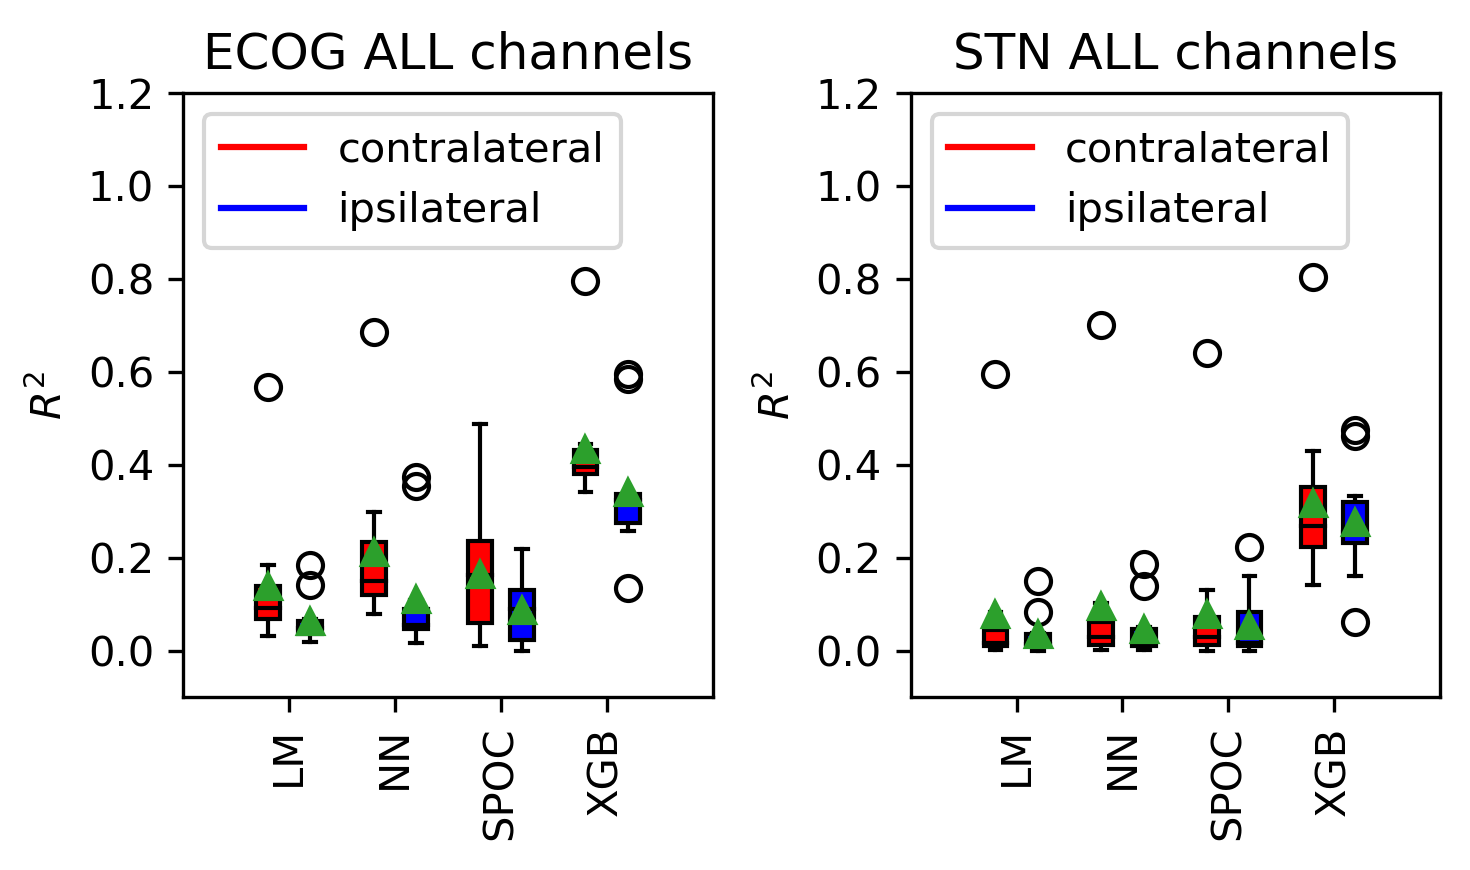

In [23]:
plt.figure(figsize=(5,3), dpi=300)
plt.subplot(121)
plt.title('ECOG ALL channels')
my_box_plot_comparison_here([ecog_con_LM_, ecog_con_NN_, SPOC_ECOG_CON_tlag, ecog_con_RF_], \
                            [ecog_ips_LM_, ecog_ips_NN_, SPOC_ECOG_IPS_tlag, ecog_ips_RF_], \
                            label_1='contralateral', label_2='ipsilateral')

plt.subplot(122)
plt.title('STN ALL channels')
my_box_plot_comparison_here([stn_con_LM_, stn_con_NN_, SPOC_STN_CON_tlag, stn_con_RF_], \
                            [stn_ips_LM_, stn_ips_NN_, SPOC_STN_IPS_tlag, stn_ips_RF_], \
                            label_1='contralateral', label_2='ipsilateral')
plt.ylabel(r'$R^2$')
plt.tight_layout()

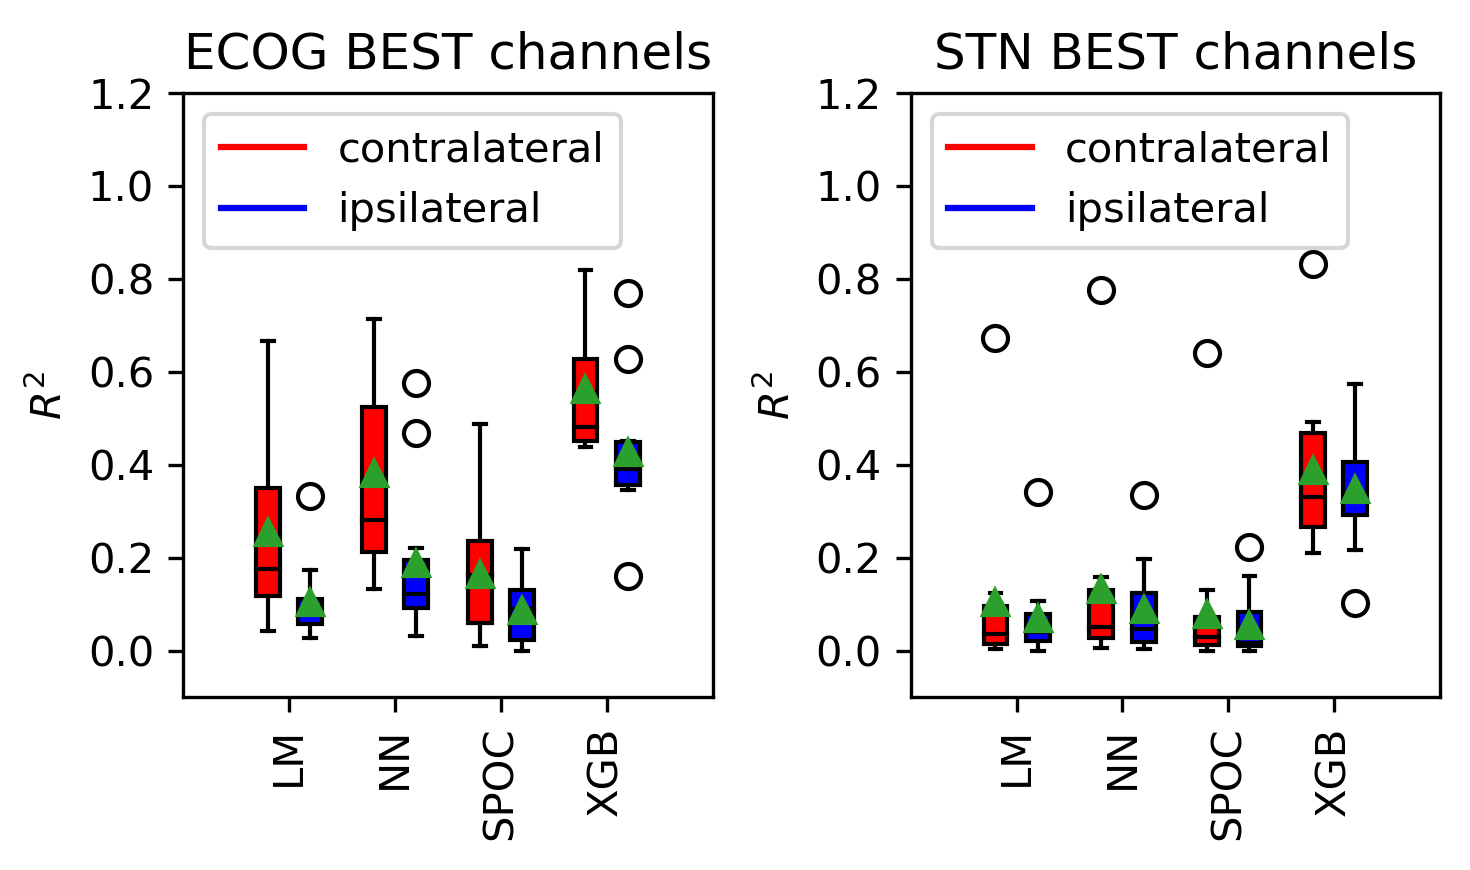

In [25]:
plt.figure(figsize=(5,3), dpi=300)
plt.subplot(121)
plt.title('ECOG BEST channels')
my_box_plot_comparison_here([res_LM["ECOG_CON_R2"], res_NN["ECOG_CON_R2"], SPOC_ECOG_CON_tlag, res_XGB["ECOG_CON_R2"]], \
                            [res_LM["ECOG_IPS_R2"], res_NN["ECOG_IPS_R2"], SPOC_ECOG_IPS_tlag, res_XGB["ECOG_IPS_R2"]], \
                            label_1='contralateral', label_2='ipsilateral')

plt.subplot(122)
plt.title('STN BEST channels')
my_box_plot_comparison_here([res_LM["STN_CON_R2"], res_NN["STN_CON_R2"], SPOC_STN_CON_tlag, res_XGB["STN_CON_R2"]], \
                            [res_LM["STN_IPS_R2"], res_NN["STN_IPS_R2"], SPOC_STN_IPS_tlag, res_XGB["STN_IPS_R2"]], \
                            label_1='contralateral', label_2='ipsilateral')
plt.ylabel(r'$R^2$')
plt.tight_layout()

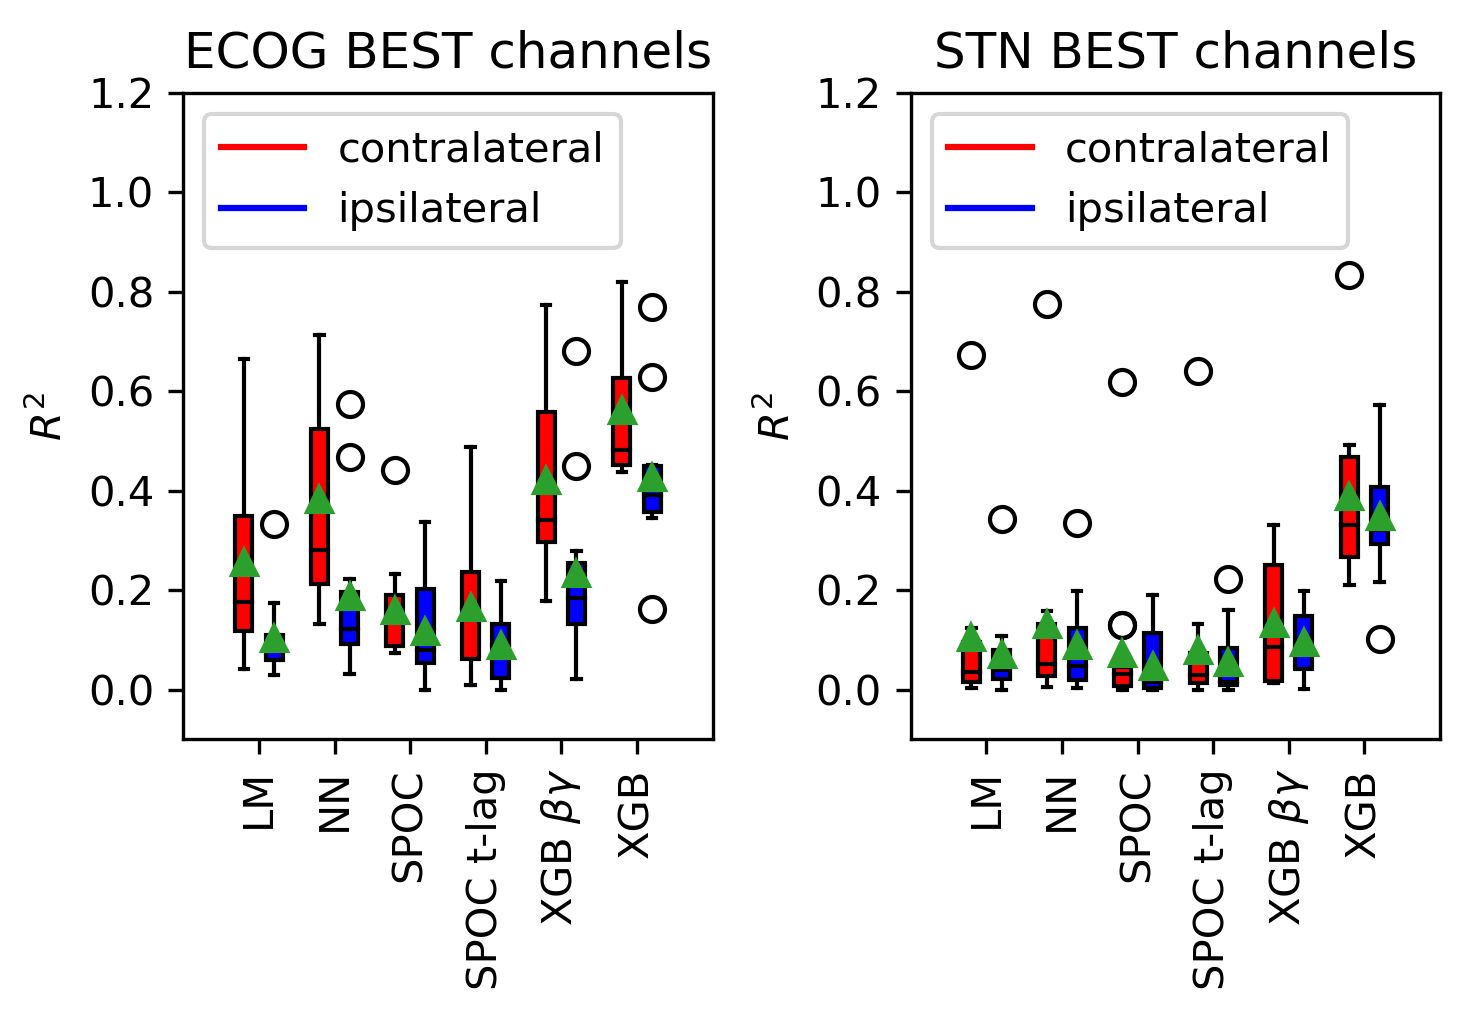

In [45]:
plt.figure(figsize=(5,3.5), dpi=300)
plt.subplot(121)
plt.title('ECOG BEST channels')
my_box_plot_comparison_here([res_LM["ECOG_CON_R2"], res_NN["ECOG_CON_R2"], SPOC_ECOG_CON, SPOC_ECOG_CON_tlag, res_XGB_bg["ECOG_CON_R2"], res_XGB["ECOG_CON_R2"]], \
                            [res_LM["ECOG_IPS_R2"], res_NN["ECOG_IPS_R2"], SPOC_ECOG_IPS, SPOC_ECOG_IPS_tlag, res_XGB_bg["ECOG_IPS_R2"], res_XGB["ECOG_IPS_R2"]], \
                            label_1='contralateral', label_2='ipsilateral')

plt.subplot(122)
plt.title('STN BEST channels')
my_box_plot_comparison_here([res_LM["STN_CON_R2"], res_NN["STN_CON_R2"], SPOC_STN_CON, SPOC_STN_CON_tlag, res_XGB_bg["STN_CON_R2"], res_XGB["STN_CON_R2"]], \
                            [res_LM["STN_IPS_R2"], res_NN["STN_IPS_R2"], SPOC_STN_IPS, SPOC_STN_IPS_tlag, res_XGB_bg["STN_IPS_R2"], res_XGB["STN_IPS_R2"]], \
                            label_1='contralateral', label_2='ipsilateral')
plt.ylabel(r'$R^2$')
plt.tight_layout()

In [37]:
print(str(np.mean(res_LM["ECOG_CON_R2"]))+" "+str(np.std(res_LM["ECOG_CON_R2"])))

0.16278191448035925 0.1423565376221248


In [38]:
print(str(np.mean(res_LM["ECOG_IPS_R2"]))+" "+str(np.std(res_LM["ECOG_IPS_R2"])))

0.08511611927973833 0.07381536568204883


In [39]:
print(str(np.mean(res_LM["STN_CON_R2"]))+" "+str(np.std(res_LM["STN_CON_R2"])))

0.08072369968418011 0.15669523577552638


In [40]:
print(str(np.mean(res_LM["STN_IPS_R2"]))+" "+str(np.std(res_LM["STN_IPS_R2"])))

0.04882948735788523 0.06256878041888031


In [42]:
print(str(np.mean(res_XGB["ECOG_CON_R2"]))+" "+str(np.std(res_XGB["ECOG_CON_R2"])))
print(str(np.mean(res_XGB["ECOG_IPS_R2"]))+" "+str(np.std(res_XGB["ECOG_IPS_R2"])))
print(str(np.mean(res_XGB["STN_CON_R2"]))+" "+str(np.std(res_XGB["STN_CON_R2"])))
print(str(np.mean(res_XGB["STN_IPS_R2"]))+" "+str(np.std(res_XGB["STN_IPS_R2"])))

0.562448303030303 0.12959933710770533
0.4279018181818182 0.15116145733587755
0.38889378787878787 0.170974436402395
0.3488243939393939 0.12795917088008799


In [43]:
print(str(np.mean(res_NN["ECOG_CON_R2"]))+" "+str(np.std(res_NN["ECOG_CON_R2"])))
print(str(np.mean(res_NN["ECOG_IPS_R2"]))+" "+str(np.std(res_NN["ECOG_IPS_R2"])))
print(str(np.mean(res_NN["STN_CON_R2"]))+" "+str(np.std(res_NN["STN_CON_R2"])))
print(str(np.mean(res_NN["STN_IPS_R2"]))+" "+str(np.std(res_NN["STN_IPS_R2"])))

0.38301954329060933 0.2052254693476139
0.18829126815298353 0.16612280652150582
0.1327329148813442 0.20919571074158305
0.089512515811184 0.09842684031063025


In [48]:
stats.ttest_rel(np.arctanh(res_XGB["ECOG_CON_R2"]),
                np.arctanh(res_XGB["ECOG_IPS_R2"]))

Ttest_relResult(statistic=2.0379447217563293, pvalue=0.06888370685585953)

In [49]:
stats.ttest_rel(np.arctanh(res_XGB["STN_CON_R2"]),
                np.arctanh(res_XGB["STN_IPS_R2"]))

Ttest_relResult(statistic=1.257674930648417, pvalue=0.2370850969821088)

### Best ML method 

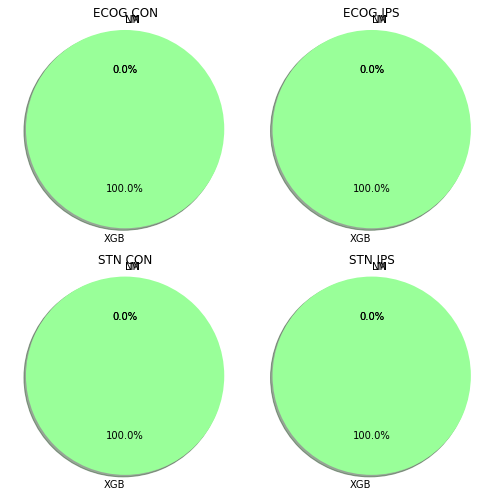

In [9]:
fig1, axs = plt.subplots(2,2, figsize=(7, 7))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
here = np.array([res_LM["ECOG_CON_R2"], res_NN["ECOG_CON_R2"], res_XGB["ECOG_CON_R2"]])
sizes = [np.where(np.argmax(here, axis=0)==0)[0].shape[0], \
         np.where(np.argmax(here, axis=0)==1)[0].shape[0],\
         np.where(np.argmax(here, axis=0)==2)[0].shape[0]]
axs[0,0].pie(sizes, labels=['LM', 'NN', 'XGB'], colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
axs[0,0].axis('equal')
axs[0, 0].set_title('ECOG CON')

here = np.array([res_LM["ECOG_IPS_R2"], res_NN["ECOG_IPS_R2"], res_XGB["ECOG_IPS_R2"]])
sizes = [np.where(np.argmax(here, axis=0)==0)[0].shape[0], \
         np.where(np.argmax(here, axis=0)==1)[0].shape[0],\
         np.where(np.argmax(here, axis=0)==2)[0].shape[0]]
axs[0,1].pie(sizes, labels=['LM', 'NN', 'XGB'], colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
axs[0,1].axis('equal')
axs[0, 1].set_title('ECOG IPS')

here = np.array([res_LM["STN_CON_R2"], res_NN["STN_CON_R2"], res_XGB["STN_CON_R2"]])
sizes = [np.where(np.argmax(here, axis=0)==0)[0].shape[0], \
         np.where(np.argmax(here, axis=0)==1)[0].shape[0],\
         np.where(np.argmax(here, axis=0)==2)[0].shape[0]]
axs[1,0].pie(sizes, labels=['LM', 'NN', 'XGB'], colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
axs[1,0].axis('equal')
axs[1, 0].set_title('STN CON')

here = np.array([res_LM["STN_IPS_R2"], res_NN["STN_IPS_R2"], res_XGB["STN_IPS_R2"]])
sizes = [np.where(np.argmax(here, axis=0)==0)[0].shape[0], \
         np.where(np.argmax(here, axis=0)==1)[0].shape[0],\
         np.where(np.argmax(here, axis=0)==2)[0].shape[0]]
axs[1,1].pie(sizes, labels=['LM', 'NN', 'XGB'], colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
axs[1,1].axis('equal')
axs[1, 1].set_title('STN IPS')

plt.tight_layout()
plt.show()

In [14]:
#parameters for the NN: alpha, l1_ratio, num_iterations
df = pd.DataFrame(np.concatenate((np.round(np.array(res_LM["ECOG_CON_P"]),8), \
                                  np.round(np.expand_dims(np.array(res_LM["ECOG_CON_R2"]), \
                                                              axis=1),2)), axis=1))
df = df.set_axis(['alpha', 'l1_ratio', 'R2 performance'], axis=1, inplace=False)

In [15]:
df

,alpha,l1_ratio,R2 performance
0,0.000000,0.000000,0.67
1,0.000000,0.000000,0.49
2,0.000305,0.993036,0.12
3,0.000000,0.000000,0.12
4,0.005188,0.272776,0.25
5,0.001344,0.984445,0.17
6,0.000000,0.000000,0.34
7,0.001301,0.143527,0.18
8,0.000000,0.000000,0.36
9,0.001625,0.375784,0.04


In [124]:
#learning_rate, num_dense_layers, num_input_nodes, num_dense_nodes, activation
df = pd.DataFrame(np.concatenate((np.concatenate((np.expand_dims(np.round(np.array(res_NN["ECOG_CON_P"])[:,0].astype(float),4), axis=1), \
            np.array(res_NN["ECOG_CON_P"])[:,1:]),axis=1), \
                                  np.round(np.expand_dims(np.array(res_NN["ECOG_CON_R2"]), \
                                                              axis=1),2)), axis=1))
df = df.set_axis(['learning_rate', 'num_dense_layers', 'num_input_nodes', 'num_dense_nodes', 'activation','R2performance'], axis=1, inplace=False)
df["learning_rate"] = df.learning_rate.astype(float)
df["num_dense_layers"] = df.num_dense_layers.astype(float)
df["num_input_nodes"] = df.num_input_nodes.astype(float)
df["num_dense_nodes"] = df.num_dense_nodes.astype(float)
df["R2performance"] = df.R2performance.astype(float)

In [126]:
df.mean(numeric_only=True)

learning_rate       0.001818
num_dense_layers    2.545455
num_input_nodes     8.454545
num_dense_nodes     6.090909
R2performance       0.382727
dtype: float64

In [14]:
space  = [Integer(1, 100, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(10**0, 10**3, "log-uniform", name='n_estimators'), 
          Real(10**0, 10**1, "uniform", name="gamma")]


In [82]:
df = pd.DataFrame(np.concatenate((np.round(res_XGB["ECOG_CON_P"],4), \
                             np.round(np.expand_dims(np.array(res_XGB["ECOG_CON_R2"]), axis=1), 2)), axis=1))
df = df.set_axis(['max_depth', 'learning_rate', 'n_estimators', 'gamma','R2 performance'], axis=1, inplace=False)

In [84]:
df.mean()

max_depth          46.909091
learning_rate       0.120791
n_estimators      501.727273
gamma               7.172282
R2 performance      0.561818
dtype: float64

### T Test Comparison

In [16]:
stats.ttest_rel(np.arctanh(res_XGB["ECOG_CON_R2"]), np.arctanh(res_XGB["STN_CON_R2"]))

Ttest_relResult(statistic=3.4656356751179707, pvalue=0.006065250917463319)

In [17]:
stats.ttest_rel(np.arctanh(res_XGB["ECOG_IPS_R2"]), np.arctanh(res_XGB["STN_IPS_R2"]))

Ttest_relResult(statistic=2.6227657322062576, pvalue=0.025476507075490658)

In [74]:
def my_box_plot_comparison(data_a, data_b, num_ =4, label_1 ='raw channel', label_2 ='grid'):
    ticks = [str(i) for i in range(num_)]
    bpl = plt.boxplot(data_a, positions=np.array(range(num_))*2.0-0.4, showmeans=True, widths=0.4, patch_artist=True)
    bpr = plt.boxplot(data_b, positions=np.array(range(num_))*2.0+0.4, showmeans=True, widths=0.4, patch_artist=True)
    set_box_color(bpl, 'r') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, 'b')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='r', label=label_1)
    plt.plot([], c='b', label=label_2)

    plt.xlim(-2, len(ticks)*2)
    plt.tight_layout()
    plt.xticks(range(0, len(ticks) * 2, 2), ['ECOG con', 'ECOG ips', 'STN con', 'STN ips'], rotation=45)
    plt.ylabel('AUC')

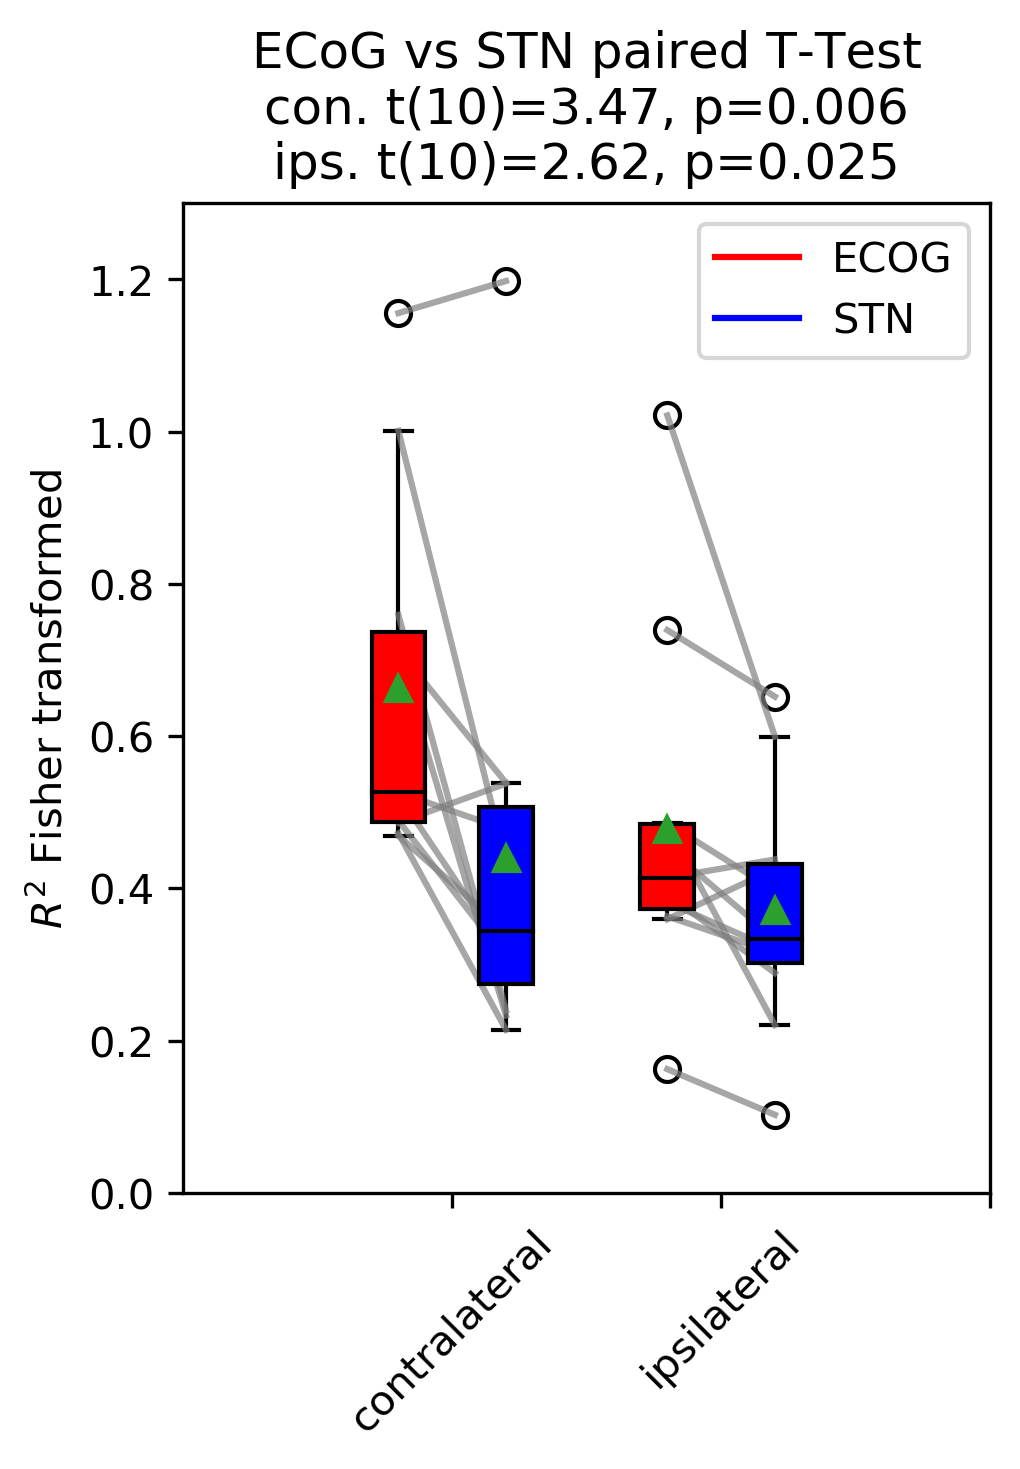

In [78]:
plt.figure(figsize=(3.5,5), dpi=300)
my_box_plot_comparison([np.arctanh(res_XGB["ECOG_CON_R2"]), np.arctanh(res_XGB["ECOG_IPS_R2"])],
    [np.arctanh(res_XGB["STN_CON_R2"]), np.arctanh(res_XGB["STN_IPS_R2"])],num_ =2, \
    label_1 ='ECOG', label_2 ='STN')

#plt.grid(True)
plt.xticks(range(0, 3*2, 2), ['contralateral', 'ipsilateral'], rotation=45)
plt.legend()
plt.title('ECoG vs STN paired T-Test\ncon. t(10)=3.47, p=0.006\nips. t(10)=2.62, p=0.025')
plt.ylim(0, 1.3)
plt.ylabel('$R^2$'+' Fisher transformed')
plt.tight_layout()
plt.plot([-0.4,0.4],np.array([np.arctanh(res_XGB["ECOG_CON_R2"]), np.arctanh(res_XGB["STN_CON_R2"])]), color='gray', alpha=0.7)
plt.plot([1.6,2.4],np.array([np.arctanh(res_XGB["ECOG_IPS_R2"]), np.arctanh(res_XGB["STN_IPS_R2"])]), color='gray', alpha=0.7)
plt.show()

### Non-Fisher transformed

In [196]:
stats.ttest_rel(res_XGB["ECOG_CON_R2"], res_XGB["STN_CON_R2"])

Ttest_relResult(statistic=3.91569252640253, pvalue=0.002886473519520802)

In [197]:
stats.ttest_rel(res_XGB["ECOG_IPS_R2"], res_XGB["STN_IPS_R2"])

Ttest_relResult(statistic=2.9477543358339675, pvalue=0.014590615833081341)

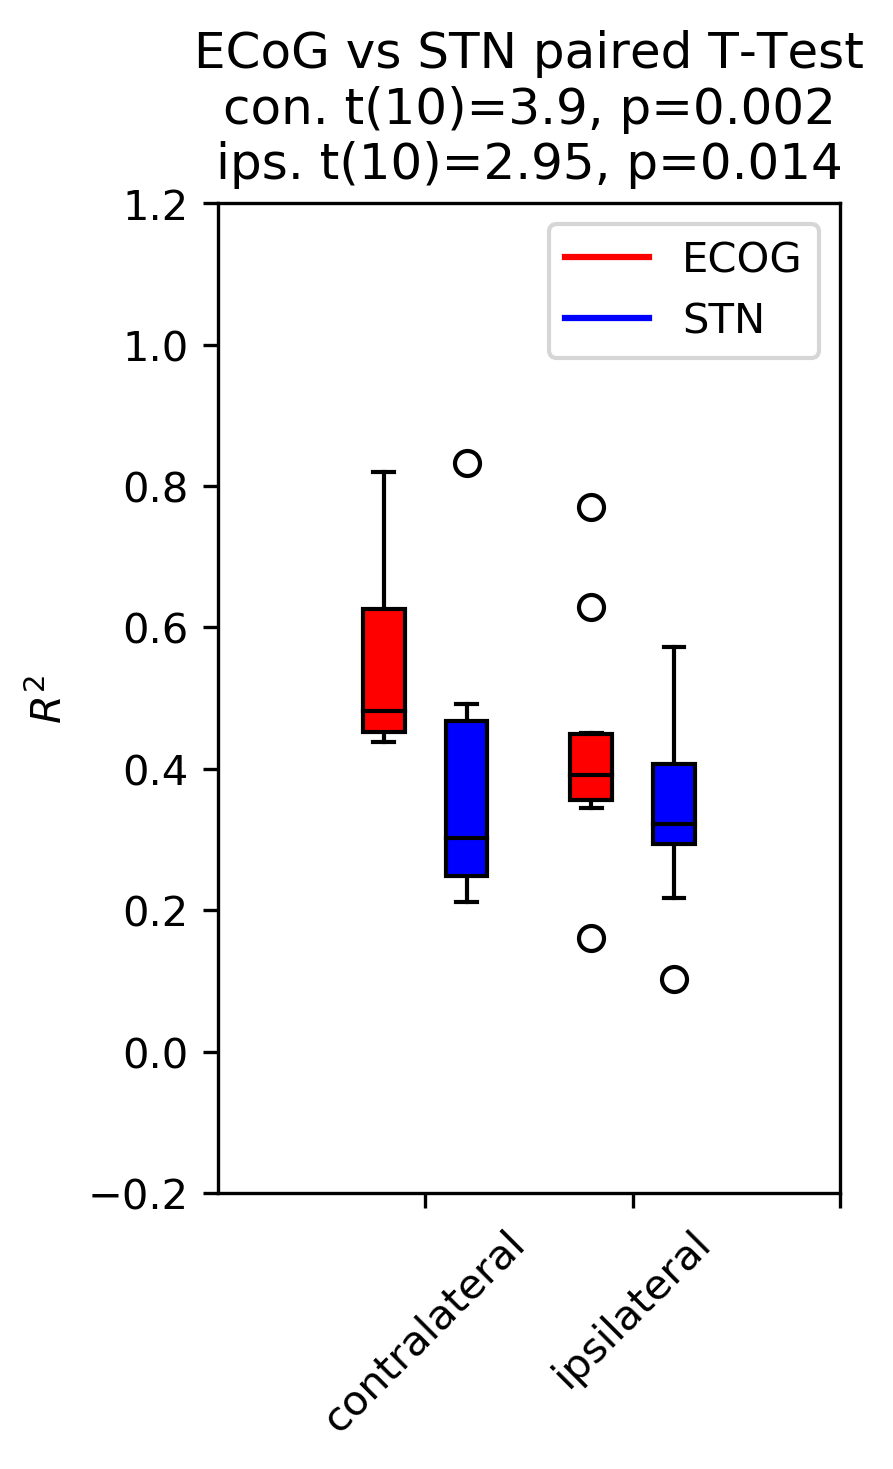

In [198]:
plt.figure(dpi=300, figsize=(3,5))
my_box_plot_comparison([res_XGB["ECOG_CON_R2"], res_XGB["ECOG_IPS_R2"]], \
                       [res_XGB["STN_CON_R2"], res_XGB["STN_IPS_R2"]], num_ =2, \
    label_1 ='ECOG', label_2 ='STN')

#plt.grid(True)
plt.xticks(range(0, 3*2, 2), ['contralateral', 'ipsilateral'], rotation=45)
#plt.plot([0.5 for i in np.arange(-1, 3*2-2, 1)], label='chance', color='black')
plt.legend()
#plt.title('LM ECoG vs STN con. t(12)=4.22, p=0.001, ips. t(12)=3.03, p=0.01')
plt.title('ECoG vs STN paired T-Test\ncon. t(10)=3.9, p=0.002\nips. t(10)=2.95, p=0.014')
plt.ylim(-0.2, 1.2)
plt.ylabel('$R^2$')
plt.tight_layout()

plt.show()